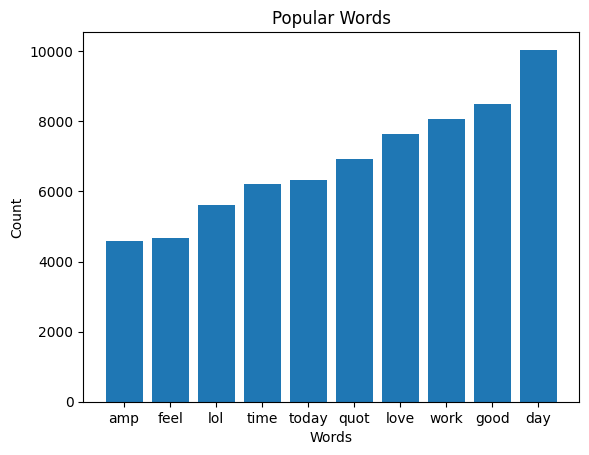

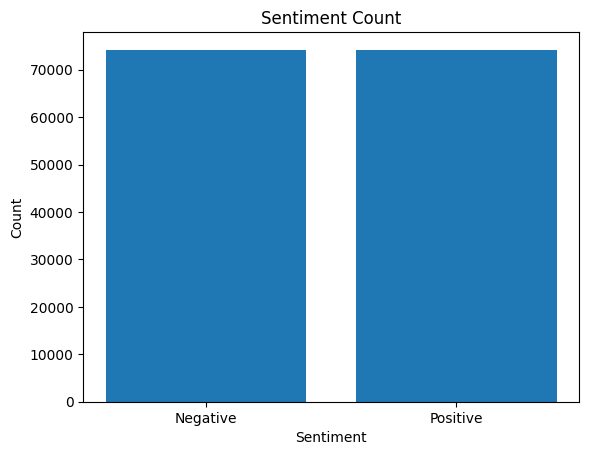

In [3]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk

csv_data = pd.read_csv("/kaggle/input/ai-2-deep-learning-for-nlp-homework-1/train_dataset.csv")

arr = csv_data.to_numpy()

def preprocess_data(arr):
    link_user_regex = re.compile(r'(@\w*)|(https?://(\w|[./])*)\s*') #remove links and usernames
    remove_symbols_regex = re.compile(r'[|{}_,/.\'\"`<>!\\@#$%^&\(\)*\-=\+/?;:~\[\]]+') #remove symbols
    remove_numbers_regex = re.compile(r'[0-9]+') #remove numbers
    not_ascii_regex = re.compile('[^ -~]') #remove non ascii chars
    for i in range(len(arr)):
        row = arr[i]
        row[1] = link_user_regex.sub("",row[1])
        row[1] = remove_symbols_regex.sub(" ",row[1])
        row[1] = not_ascii_regex.sub("",row[1])
        row[1] = remove_numbers_regex.sub("",row[1])
        row[1] = row[1].lower()
        arr[i] = row
    return arr

def remove_stopwords(arr):
    stopwords_file = "/kaggle/input/eng-stopwords/stop_words_english.txt"
    stopwords = open(stopwords_file,"r")
    stopwords = stopwords.read().splitlines()
    regex = re.compile(r'\b(' + r'|'.join(stopwords) + r')\b\s*')
    for i in range(len(arr)):
        row = arr[i]
        row[1] = regex.sub("",row[1])
        arr[i] = row
    return arr

def stemmer(arr):
    stemmer = nltk.stem.PorterStemmer()
    for i in range(len(arr)):
        row = arr[i]
        sentence = []
        for word in row[1].split():
            sentence.append(stemmer.stem(word))
        row[1] = " ".join(sentence)
        arr[i] = row
    return arr

arr = preprocess_data(arr)
arr = remove_stopwords(arr)
arr = stemmer(arr)

pos_count = 0
for i in range(len(arr)):
    pos_count += arr[i][2]

L = []
for i in range(len(arr)):
    L += arr[i][1].split()
words = np.array(L)

(words,counts) = np.unique(words,return_counts=True)
pop_words = sorted(list(zip(words,counts)),key= lambda tuple: tuple[1])
words,counts = zip(*pop_words[-10:])

plt.figure()
plt.bar(words,counts)
plt.title("Popular Words")
plt.xlabel("Words")
plt.ylabel("Count")
plt.savefig("/kaggle/working/pop_words.png")

neg_count = len(arr) - pos_count
plt.figure()
plt.bar(["Negative","Positive"],[neg_count,pos_count])
plt.title("Sentiment Count")
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.savefig("/kaggle/working/sentiment_count.png")

In [16]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score,precision_score,recall_score,accuracy_score
import sklearn.metrics
import pandas as pd
import numpy as np

train_data = pd.read_csv("/kaggle/input/ai-2-deep-learning-for-nlp-homework-1/train_dataset.csv")
val_data = pd.read_csv("/kaggle/input/ai-2-deep-learning-for-nlp-homework-1/val_dataset.csv")

def load_data(data):
    arr = data.to_numpy()
    arr = preprocess_data(arr)
    arr = remove_stopwords(arr)
    arr = stemmer(arr)
    return arr

def create_input(vectorizer,data):
    tweets = data[:,1]
    gold_labels = data[:,2]
    gold_labels = gold_labels.astype('int')
    features = vectorizer.transform(tweets)
    return (features,gold_labels)

def vectorize_input(vectorizer,data):
    tweets = data[:,1]
    features = vectorizer.transform(tweets)
    return features

def train_model(vectorizer,data):
    tweets = data[:,1]
    gold_labels = data[:,2]
    gold_labels = gold_labels.astype('int')
    features = vectorizer.fit_transform(tweets)
    clf = LogisticRegression(random_state=0,solver='saga',tol=1e-6,max_iter=200,class_weight='balanced').fit(features, gold_labels)
    return clf
                  
train = load_data(train_data)
val = load_data(val_data)

vectorizer = TfidfVectorizer()
clf = train_model(vectorizer,train)

features_val,val_gold_labels = create_input(vectorizer,val)


pred_labels = clf.predict(features_val)

print("F1: ",f1_score(val_gold_labels,pred_labels))
print("Accuracy: ",accuracy_score(val_gold_labels,pred_labels))
print("Precision: ",precision_score(val_gold_labels,pred_labels))
print("Recall: ",recall_score(val_gold_labels,pred_labels))


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


F1:  0.7479968865894419
Accuracy:  0.7403528634776866
Precision:  0.7266379041942801
Recall:  0.7706495589414595


In [ ]:
train_data = pd.read_csv("/kaggle/input/ai-2-deep-learning-for-nlp-homework-1/train_dataset.csv")
test_data = pd.read_csv("/kaggle/input/ai-2-deep-learning-for-nlp-homework-1/test_dataset.csv")

train = load_data(train_data)
test = load_data(test_data)

vectorizer = TfidfVectorizer()

clf = train_model(vectorizer,train)
test_features = vectorize_input(vectorizer,test)

pred_labels = clf.predict(test_features)

L = []
for i in range(len(pred_labels)):
    L.append([test[i,0],pred_labels[i]])

arr = np.array(L)
columns = ['ID','Label']
dataframe = pd.DataFrame(data=arr,columns=columns)

dataframe.to_csv("/kaggle/working/submission.csv",index=False)